In [1]:
import numpy as np
import matplotlib.pyplot as plt
from galaxy2galaxy import problems
import tensorflow as tf
from scipy import fftpack 
from scipy.ndimage import gaussian_filter, convolve
import pickle
from itertools import chain

tf.enable_eager_execution()

%matplotlib inline
np.seterr(divide='ignore', invalid='ignore')

tf.version.VERSION

'1.15.0'

In [2]:
import sys
path = '/home/astro/akhaury/GitHub/ADMM/'
sys.path.insert(1, path)

import plot_utils
from helper_func import *

data_path = '/home/astro/akhaury/Data/'

SyntaxError: invalid syntax (plot_utils.py, line 27)

In [ ]:
tf.executing_eagerly()

### Pre-processing Function

In [4]:
SNR = 80.0

def pre_proc_unet(dico):
    r"""Preprocess the data and adds noise to generate the input galaxy images.

    This function takes the dictionnary of galaxy images and PSFs for the input and
    the target and returns a list containing 3 arrays: an array of noisy galaxy images, 
    an array of target galaxy images, and an array of PSFs

    Parameters
    ----------
    dico : dictionnary
        Array_like means all those objects -- lists, nested lists, etc. --
        that can be converted to an array.  We can also refer to
        variables like `var1`.

    Returns
    -------
    list
        list containing 3 arrays: an array of noisy galaxy images, 
        an array of target galaxy images, and an array of PSFs
    
    Example
    -------
    These are written in doctest format, and should illustrate how to
    use the function.

    >>> from galaxy2galaxy import problems # to list avaible problems run problems.available()
    >>> problem128 = problems.problem('attrs2img_cosmos_hst2euclide')
    >>> dset = problem128.dataset(Modes.TRAIN, data_dir='attrs2img_cosmos_hst2euclide')
    >>> dset = dset.map(pre_proc_unet)
    """
    # Add noise
    # For the estimation of CFHT noise standard deviation check section 3 of:
    # https://github.com/CosmoStat/ShapeDeconv/blob/master/data/CFHT/HST2CFHT.ipynb

    sigma = tf.norm(dico['inputs']) / SNR
    noise = tf.random_normal(shape=tf.shape(dico['inputs']), mean=0.0, stddev=sigma, dtype=tf.float32)
    dico['inputs'] = dico['inputs'] + noise
    dico['targets'] /= 4000
    dico['inputs'] /= 4000
    dico['psf'] = dico['psf_cfht']/dico['psf_hst']
    
    # Compute IRFFT of PSF
    dico['psf'] = tf.signal.ifftshift(tf.signal.irfft2d(tf.cast(tf.squeeze(dico['psf']), tf.complex64)))
    
    # Resize to 64 X 64 using area interpolation
    dico['psf'] = tf.squeeze(tf.image.resize(tf.expand_dims(dico['psf'], axis=-1), size=(64,64), method='area'))
    
    # Normalize the PSF
    dico['psf'] /= tf.math.reduce_sum(dico['psf'])
    
    # Correct the miscentering error
    shift = [-1,-1]
    return tf.roll(tf.squeeze(dico['inputs']), shift, axis=[0,1]), tf.roll(tf.squeeze(dico['targets']), shift, axis=[0,1]), tf.roll(tf.squeeze(dico['psf']), shift, axis=[0,1]), sigma


### Loading Galaxy Images & PSF

In [5]:
with tf.compat.v1.Session() as sess:
    
    # Let's create an instance of the meerkat_3600 problem
    Modes = tf.estimator.ModeKeys
    problem128 = problems.problem('attrs2img_cosmos_parametric_cfht2hst')
    dset = problem128.dataset(Modes.EVAL, data_dir=data_path+'attrs2img_cosmos_parametric_cfht2hst')
    dset = dset.repeat()
    dset = dset.map(pre_proc_unet)
    n_batch = 128
    dset = dset.batch(n_batch)

    # Build an iterator over the dataset
    iterator = dset.make_one_shot_iterator().get_next()

    # Initialize batch
    batch = sess.run(iterator)


INFO:tensorflow:Reading data files from /home/astro/akhaury/Data/attrs2img_cosmos_parametric_cfht2hst/attrs2img_cosmos_parametric_cfht2hst-dev*
INFO:tensorflow:partition: 0 num_data_files: 2

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




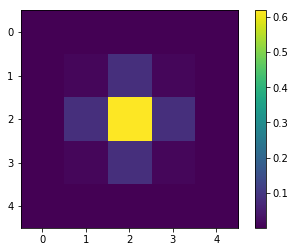

0.9999999999999999


In [6]:
dirac = np.zeros((64,64))
dirac[64//2, 64//2] = 1.0
gauss_kern = gaussian_filter(dirac, 0.5)
plt.imshow(gauss_kern[30:35, 30:35]); plt.colorbar(); plt.show()
print(np.sum(gauss_kern))

In [7]:
for i in range(128):
    
    batch[1][i] = convolve(batch[1][i], gauss_kern, mode='constant', cval=0.0)
    batch[2][i] = np.squeeze(fftpack.fftshift(fftpack.ifftn(fftpack.ifftshift(fftpack.fftshift(fftpack.fftn(batch[2][i]))/fftpack.fftshift(fftpack.fftn(gauss_kern))))))

/astro/soft/common/gcc/5.4.0/python/3.7.1/lib/python3.7/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x
/astro/soft/common/gcc/5.4.0/python/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.


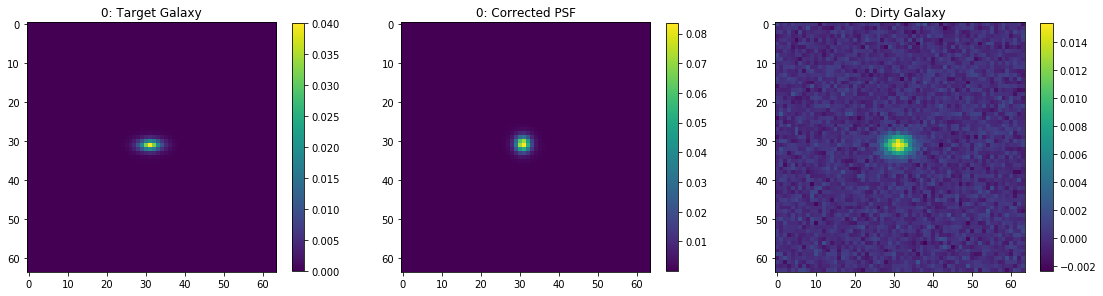

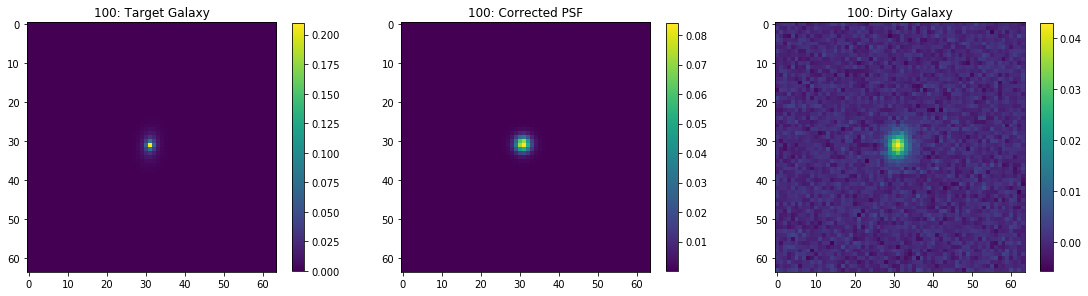

In [8]:
for i in range(0, n_batch, 100):
    plt.figure(figsize=(19,19))
    plt.subplot(131)
    plt.imshow(np.squeeze(batch[1][i])); plt.colorbar(shrink=0.24); plt.title('{}: Target Galaxy'.format(i))
    plt.subplot(132)
    plt.imshow(np.squeeze(batch[2][i])); plt.colorbar(shrink=0.24); plt.title('{}: Corrected PSF'.format(i))
    plt.subplot(133)
    plt.imshow(np.squeeze(batch[0][i])); plt.colorbar(shrink=0.24); plt.title('{}: Dirty Galaxy'.format(i))
    plt.show()

### Load Trained U-Net Model

In [9]:
model_1 = tf.keras.models.load_model(path+'UNet_Denoiser/Models/UNet_param_ep{10}spe{6250}nb{32}', compile=False)

# Forward-Backward Algorithm

#### The loss function

$ L(x) = \frac{1}{2\sigma^2} \lVert Hx - y \rVert_2^2 \\\\\\ 
\nabla L(x) = \frac{1}{\sigma^2} H^T(Hx - y)  \\\\\\
\nabla L(x_{true}) = \frac{1}{\sigma^2} H^Tn; \hspace{0.75cm} since \hspace{0.5cm} y = Hx_{true} + n\hspace{0.75cm} s.t. \hspace{0.5cm} n \hspace{0.25cm} WAGN \\\\\\ $

#### Compute Variance of -

$ \hspace{0.75cm} \alpha\nabla L(x_{true}) = \frac{\alpha}{\sigma^2} H^Tn \\\\\\ 
\hspace{0.75cm} \text {Cov[} \alpha \nabla L(x_{true})] = \frac{\alpha^2}{\sigma^4} \text {Cov[}(H^Tn)] = \frac{\alpha^2}{\sigma^4} \sigma^2 H^T H;  \hspace{0.75cm} \text{as  Cov(} H^Tn) = H^T \text{Cov(} n) (H^T)^T \\\\\\
\Rightarrow \hspace{0.25cm} {Cov[} \alpha \nabla L(x_{true})] = \frac{\alpha^2}{\sigma^2} H^TH \\\\\\ $

#### Now, 

$\hspace{0.8cm} AA^T [i,i] = \sum_j A[i,j]A^T[j,i] = \sum_j A^2[i,j] = \lVert A \rVert_F^2 \\\\\\ 
\therefore \hspace{0.25cm} \text {Cov(} \alpha \nabla L(x_{true}))[i,i] = \frac{\alpha^2}{\sigma^2} \lVert H \rVert_F^2 \\\\\\ 
\Rightarrow \hspace{0.25cm} \sigma_{grad} = \alpha \lVert H \rVert_F \sigma_{U-Net}\\\\\\ $


#### After plugging U-Net

$ L(x) = L_d + p(x), \hspace{0.75cm} where \hspace{0.5cm} L_d(x) = \frac{1}{2\sigma^2} \lVert Hx - y \rVert_2^2\\\\\\ $

##### Forward backward Splitting
While not converged:
$ \hspace{0.5cm} X^{(k+\frac{1}{2})} \leftarrow X^{(k)} - \alpha \nabla L_d(X^{(k)}) $
$\\\\\\ \hspace{4.1cm} X^{(k+1)} \leftarrow prox_\alpha X^{(k+\frac{1}{2})} \\\\\\ $

Note that: 
$ \hspace{0.5cm} Var (\frac{\sigma_0}{\sigma}n) = \frac{\sigma_0^2}{\sigma^2} Var(n) = \sigma_0^2$

##### Empirically estimate standard deviation of $\alpha \nabla L_d(x_{true})$ : $\hspace{0.5cm} \alpha H^T  n$
$ \hspace{0.5cm}x^{(0)} = 0 $
$ \\\\\\ \hspace{0.5cm}x^{(\frac{1}{2})} = x^{(0)} - \alpha \nabla L_d(x_{true}) $
$ \hspace{0.5cm}x^{(\frac{1}{2})} = \alpha H^T n $
$ \\\\\\ \hspace{0.5cm}Hx_{true} - y = n $

##### Check if:

$ \\\\\\ \hspace{0.5cm}np.std(x^{(\frac{1}{2})}) = np.std(\alpha H^T n) \hspace{1.0cm} (Empirical \hspace{0.175cm} value) \\\\\\ \hspace{2.75cm} = \alpha \lVert H \rVert_F \sigma \hspace{2.05cm} (Theoretical \hspace{0.175cm} value) $


In [29]:
# Projection - Enforce non-negative values
def proj(xi):
    
    return tf.cast(tf.math.maximum(xi, 0.0), tf.float32)
 
    
# H operator
def H(data, psf):
    
    return fftconvolve(data, psf)


# H transpose operator
def Ht(data, psf):
    
    return fftconvolve(data, tf.reverse(tf.reverse(psf, axis=[0]), axis=[1]))      # rotate by 180


# The gradient
def grad(y, x_rec, psf):

    return Ht(H(x_rec, psf) - y, psf)


# The cost function
def cost_func(y, x_rec, psf, var):

    L_d = (tf.cast(0.5, tf.float32) / var) * tf.norm(y - H(x_rec, psf))**2      
    return tf.keras.backend.eval(L_d)


# Spectral value
def max_sv(psf):
    
    H = tf.signal.fft2d(tf.cast(psf, tf.complex64))
    normH = tf.math.abs(tf.reverse(tf.reverse(H, axis=[0]), axis=[1]) * H)
    return tf.cast(tf.math.reduce_max(normH), tf.float32)
     
    
# Compute gradient step size   
def get_alpha(sv):

    return (tf.cast(1.0, tf.float32) / (sv * tf.cast(1.0 + 1.0e-5, tf.float32)))


def runFBS(y, x_0, psf, grad, sigma, n_iter, disp_step, model):    

    # Convert arrays to tensors 
    x_0 = tf.cast(x_0, tf.float32)
    x_k = x_0     
    sigma = tf.cast(sigma, tf.float32)

    # declare variables    
    cost = np.full(n_iter, np.inf)
    nmse_arr = np.full(n_iter, np.inf)
    
    # FISTA parameters  
    x_k = x_0
    t_k = tf.cast(1.0, tf.float32)
      
    # square of spectral radius of convolution matrix
    sv = max_sv(psf)           

    # The gradient descent step
    alpha = get_alpha(sv) 

    
    for k in range(n_iter):
        
#         ## Gradient Descent update  
#         x_k1 = x_k - alpha * grad(y, x_k, psf)  

        ## FISTA update
        x_k1 = x_k - alpha * grad(y, x_k, psf) 
#         x_k1 = proj(x_k1)      
                                            
        t_k1 = ( (tf.cast(1.0, tf.float32) + tf.math.sqrt(tf.cast(4.0, tf.float32)*t_k**2 + tf.cast(1.0, tf.float32))) 
                / tf.cast(2.0, tf.float32) )
        
        lambda_fista = tf.cast(1.0, tf.float32) + (t_k -  tf.cast(1.0, tf.float32)) / t_k1
        x_k1 = x_k + lambda_fista * (x_k1 - x_k)  
        
        # U-Net Denoising
        x_k1 = tf.expand_dims(tf.expand_dims(x_k1, axis=0), axis=-1)
        x_k1 = tf.cast(tf.squeeze(model(x_k1)), tf.float32)
        
        ## Cost
        cost[k] = cost_func(y, x_k1, psf, var=sigma**2)  
    
        # Update variables
        x_k = x_k1
                
        # Compute NMSE
        nmse_arr[k] = nmse(gal_target, x_k)  
        
        # Stopping Criteria
        if (np.abs(nmse_arr[k]-nmse_arr[k-1]) < 1e-8) or (np.abs(cost[k]-cost[k-1]) < 1e-8):
            return x_k, cost, nmse_arr

        # Display plots
        if (k+1)%disp_step==0:
            plot_utils.plot_iter(x_k, gal_target, y, k+1)
                 
    return x_k, cost, nmse_arr

### Run FBS



 Galaxy Index = 21




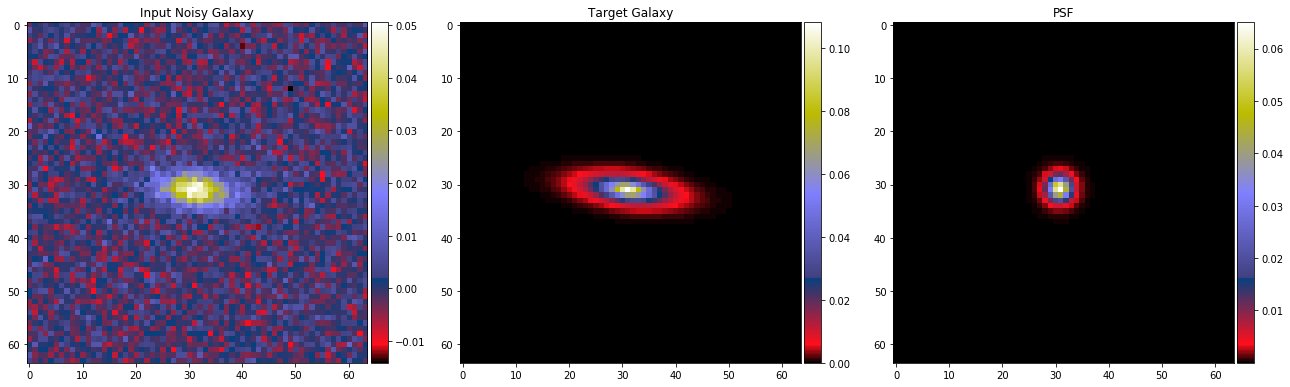

Noise Std = 0.0035230863094329835
SNR = 80.0
PSF Flux =  1.0


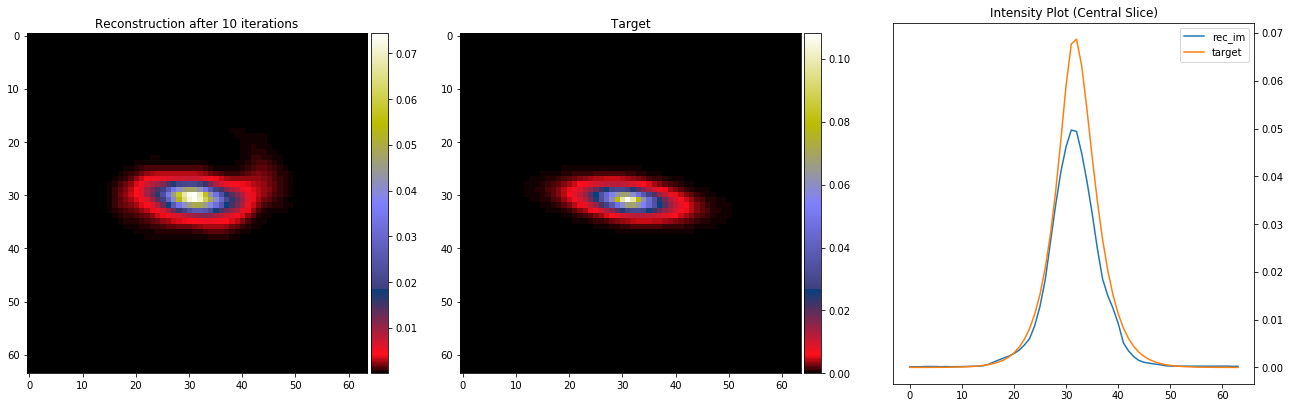

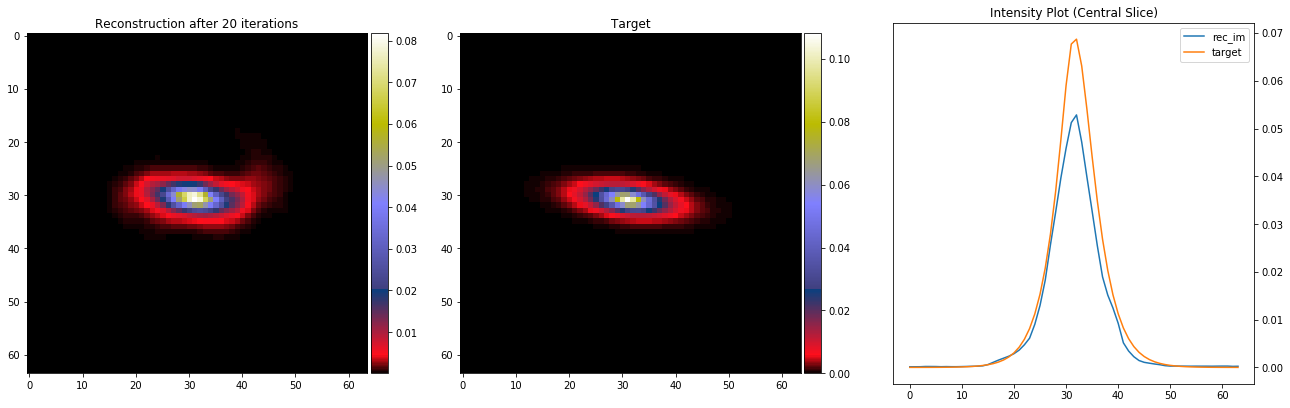


Flux after reconstruction =  4.3184927380643785
Target Flux =  3.6036565
Error =  0.1983641342224981


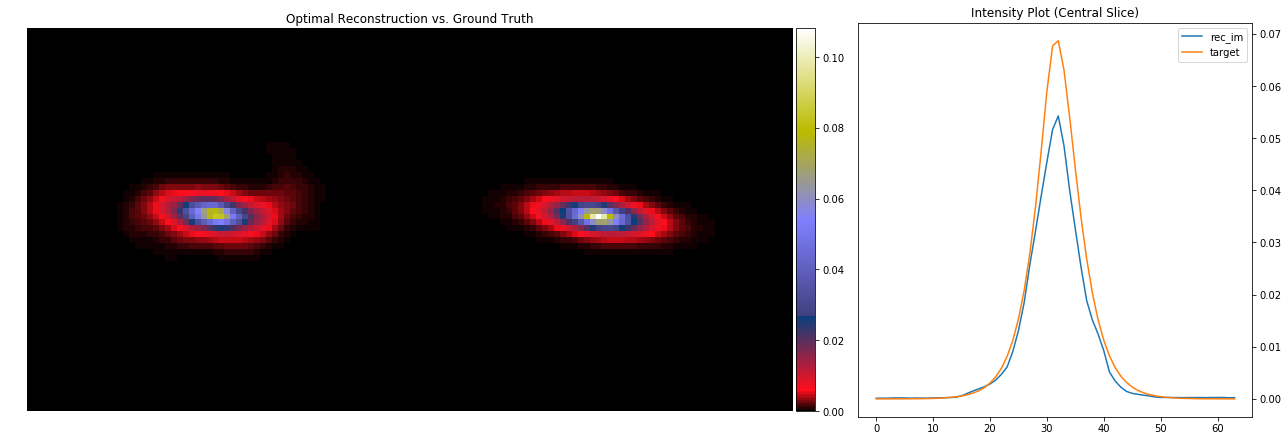

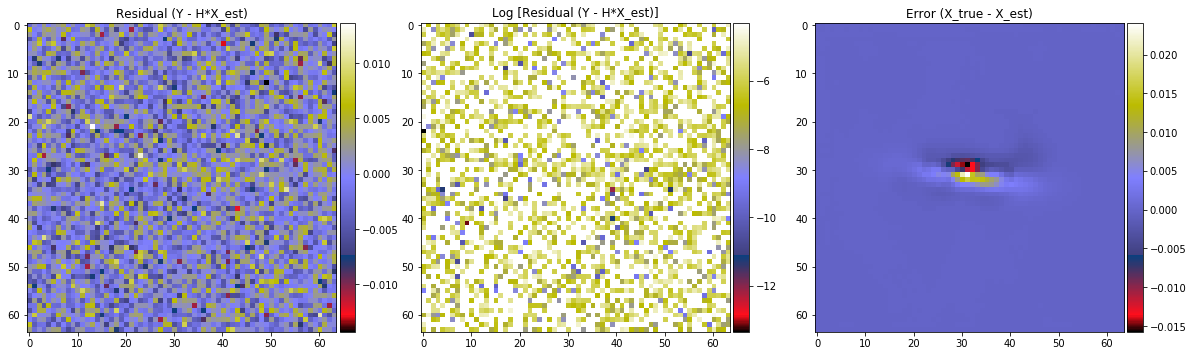

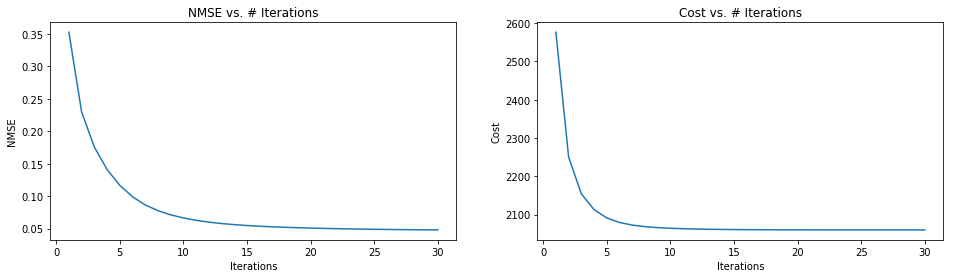


Minimum NMSE = 0.04804658144712448 (at [30] iterations)
Minimum Cost = 2060.005126953125 (at [29 30] iterations)

_______________________________________________________________________________________________________




In [30]:
n_iter = 100
disp_step = 10
n_gal_deconv = n_batch

x_0 = np.zeros(batch[0][0].shape)

x_opt = np.zeros((n_gal_deconv, batch[0].shape[1], batch[0].shape[2]))                                 
nmse_arr = np.zeros((n_gal_deconv, n_iter))          
cost = np.zeros((n_gal_deconv, n_iter)) 


# Deconvolve given images
for gal_ind in [21]:            
    
    gal_input = tf.cast(np.squeeze(batch[0][gal_ind]), tf.float32)
    gal_target = np.squeeze(batch[1][gal_ind])
    psf = tf.cast(np.squeeze(batch[2][gal_ind]) , tf.float32)  
    sigma = batch[3][gal_ind] / 4000.0    

    if gal_ind%1 == 0:
        
        print('\n\n Galaxy Index = {}'.format(gal_ind))
        
        # Plot input, target & psf 
        plot_utils.plot_gal_psf_opt(gal_input, gal_target, psf, sigma, SNR)

    # Deconvolve the image
    x_opt[gal_ind], cost[gal_ind], nmse_arr[gal_ind] = runFBS(gal_input, x_0, psf, grad, sigma, 
                                                              n_iter, disp_step, model_1)
    if gal_ind%1 == 0:
        
        # Visual Comparison
        plot_utils.comparison(x_opt[gal_ind], gal_target, gal_input, psf, fftconvolve, gs=True)

        # Plot NMSE & Cost
        plot_utils.nmse_cost(nmse_arr[gal_ind], cost[gal_ind], n_iter)


### Save Output

In [12]:
FBS_output_opt = {}
FBS_output_opt['x_opt'] = x_opt
FBS_output_opt['nmse'] = nmse_arr
FBS_output_opt = dict(chain.from_iterable(d.items() for d in (FBS_output_opt, batch)))

AttributeError: 'tuple' object has no attribute 'items'

In [ ]:
# Save FBS Output
f = open(data_path + "FBS_output_opt.pkl", "wb")
pickle.dump(FBS_output_opt, f)
f.close()

### Check Saved Batch

In [ ]:
# Load FBS Output
f = open(data_path + "FBS_output_opt.pkl", "rb")
dat = pickle.load(f)
f.close()

for key in dat:
    print(key, (dat[key] == FBS_output_opt[key]).all())